# Analysis of Packing density

In [27]:
import numpy as np
from scipy.spatial.distance import cdist # For calculating QPSK decoding
import dill
from itertools import product, cycle

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow.keras.backend as K

In [28]:
from CommVAE import CommVAE1hot
from AEOshea import AEOshea1hot

In [29]:
blkSize     = 8
chDim       = 4

# Input
inVecDim   = 2 ** blkSize  # 1-hot vector length for block
encDim = 2*chDim

SNR_range_dB = np.arange( 0.0, 11.0, 1.0 )

one_hot_code = np.eye(inVecDim)

In [30]:
model_summary = {}
results = {}

if blkSize==8 and chDim==4:
    model_summary = { 
        "[1]": "./models_08x04/rbf_oshea_64_32_16_10dB_summary.dil",
#         "AWGN ($\sigma_n^2=0.4$)": "./models_08x04/rbf_awgn_64_32_16_n040_summary.dil",
        "Proposed: Trained with (19)": "./models_08x04/rbf_awgn_64_32_16_n080_summary.dil",
#         "AWGN ($\sigma_n^2=1.2$)": "./models_08x04/rbf_awgn_64_32_16_n120_summary.dil",
#         "RBF ($\sigma_n^2=0.4$)": "./models_08x04/rbf_rbf_64_32_16_n040_summary.dil",
        "Proposed: Trained with (23)": "./models_08x04/rbf_rbf_64_32_16_n080_summary.dil",
#         "RBF ($\sigma_n^2=1.2$)": "./models_08x04/rbf_rbf_64_32_16_n120_summary.dil",
#         "Oshea ($4dB$)": "./models_08x04/rbf_oshea_64_32_16_04dB_summary.dil",
    }
elif blkSize==4 and chDim==2:
    model_summary = {
        "[1]": "./models_04x02/rbf_oshea_64_32_16_10dB_summary.dil",
#         "AWGN($\sigma_n^2=0.2$)": "./models_04x02/rbf_awgn_64_32_16_n020_summary.dil",
        "Proposed: Trained with (19)": "./models_04x02/rbf_awgn_64_32_16_n040_summary.dil",
#         "AWGN($\sigma_n^2=0.6$)": "./models_04x02/rbf_awgn_64_32_16_n060_summary.dil",
#         "RBF($\sigma_n^2=0.2$)": "./models_04x02/rbf_rbf_64_32_16_n020_summary.dil",
        "Proposed: Trained with (23)": "./models_04x02/rbf_rbf_64_32_16_n040_summary.dil",
#         "RBF($\sigma_n^2=0.6$)": "./models_04x02/rbf_rbf_64_32_16_n060_summary.dil",
#         "Oshea ($4dB$)": "./models_04x02/rbf_oshea_64_32_16_04dB_summary.dil",
    }
elif blkSize==2 and chDim==1:
    model_summary = {
        "[1]": "./models_02x01/rbf_oshea_64_32_16_10dB_summary.dil",
        "Proposed: Trained with (19)": "./models_02x01/rbf_awgn_64_32_16_n020_summary.dil",
        "Proposed: Trained with (23)": "./models_02x01/rbf_rbf_64_32_16_n020_summary.dil",
    }
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

In [31]:
import os.path
for (model_exp, summary_file) in model_summary.items():
    log_msg = "{:40s}    {:70s}".format(model_exp,summary_file)
    if os.path.isfile(summary_file):
        log_msg += "EXISTS"
    else:
        log_msg += "NOT FOUND"
    print(log_msg)

[1]                                         ./models_08x04/rbf_oshea_64_32_16_10dB_summary.dil                    EXISTS
Proposed: Trained with (19)                 ./models_08x04/rbf_awgn_64_32_16_n080_summary.dil                     EXISTS
Proposed: Trained with (23)                 ./models_08x04/rbf_rbf_64_32_16_n080_summary.dil                      EXISTS


Create a dictionary and then convert to dataframe is fast than inserting to a DF. Ref: https://stackoverflow.com/a/47979665/8957978

In [32]:
for (model_exp,summary_file) in model_summary.items():
    summary_data = {}
    file_prefix = None
    # Load file
    results[model_exp] = {}
    with open(summary_file, "rb") as file:
        file_prefix = summary_file.split("_summary.dil")[0]
        summary_data = dill.load(file)
    for (modelid,(sym_pow,bler)) in summary_data.items():
        config_file = file_prefix + "_" + modelid + ".dil"
        config = {}
        model = None
        with open(config_file, "rb") as cfg_file:
            config = dill.load(cfg_file)
        if 'obj_fn' in config:    # obj_fn is there only for proposed CommVAE
            model = CommVAE1hot()
        else:
            model = AEOshea1hot()
        model.load_model(file_prefix+"_"+modelid)
        # Compute the Tx power and packing density
        dl_map = model.encode(one_hot_code)
        dl_sym_pow = np.mean(np.sum(dl_map*dl_map,axis=1))
        unique_sym_distances = np.unique(cdist(dl_map,dl_map))
        if len(unique_sym_distances) == 1: # All distances are same and will be zero
            dl_d_min = np.inf  # This is not a valid point
            dl_en = np.nan
        else:
            dl_d_min = np.unique(cdist(dl_map,dl_map))[1]
            dl_en = dl_sym_pow / (dl_d_min**2)
        assert(np.abs(sym_pow-dl_sym_pow)<1e-3) # To make sure that we loaded right weights to model
        # save the results
        # Add this results only if this is a valid point
        if np.isfinite(dl_en):
            results[model_exp][modelid] = {}
            results[model_exp][modelid]["en"] = dl_en
            results[model_exp][modelid]["dmin"] = dl_d_min
            results[model_exp][modelid]["sym_pow"] = sym_pow
            results[model_exp][modelid]["bler"] = bler
        # Clear Session and Model
        K.clear_session()
        del model

W0720 14:45:28.437386 140488416368384 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.
W0720 14:45:29.322165 140488416368384 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.
W0720 14:45:30.292730 140488416368384 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.
W0720 14:45:31.218417 140488416368384 training_utils.py:1101] Output postnoise_dec_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to postnoise_dec_out.
W0720 14:45:32.13803

Convert to dataframe

In [33]:
data = {}

for (label, result) in results.items():
    data[label] = pd.DataFrame.from_dict(result, orient='index')

In [34]:
for (label, df) in data.items():
#     summary_file = model_summary[label]
    df_file = "{}.h5".format(model_summary[label].split(".dil")[0])
    print(label, "=>", model_summary[label], "=>", df_file)
    df.to_hdf(df_file, key='table', mode='w', format='fixed')

[1] => ./models_08x04/rbf_oshea_64_32_16_10dB_summary.dil => ./models_08x04/rbf_oshea_64_32_16_10dB_summary.h5
Proposed: Trained with (19) => ./models_08x04/rbf_awgn_64_32_16_n080_summary.dil => ./models_08x04/rbf_awgn_64_32_16_n080_summary.h5
Proposed: Trained with (23) => ./models_08x04/rbf_rbf_64_32_16_n080_summary.dil => ./models_08x04/rbf_rbf_64_32_16_n080_summary.h5


Exploratory Visualizations

Text(0, 0.5, 'density')

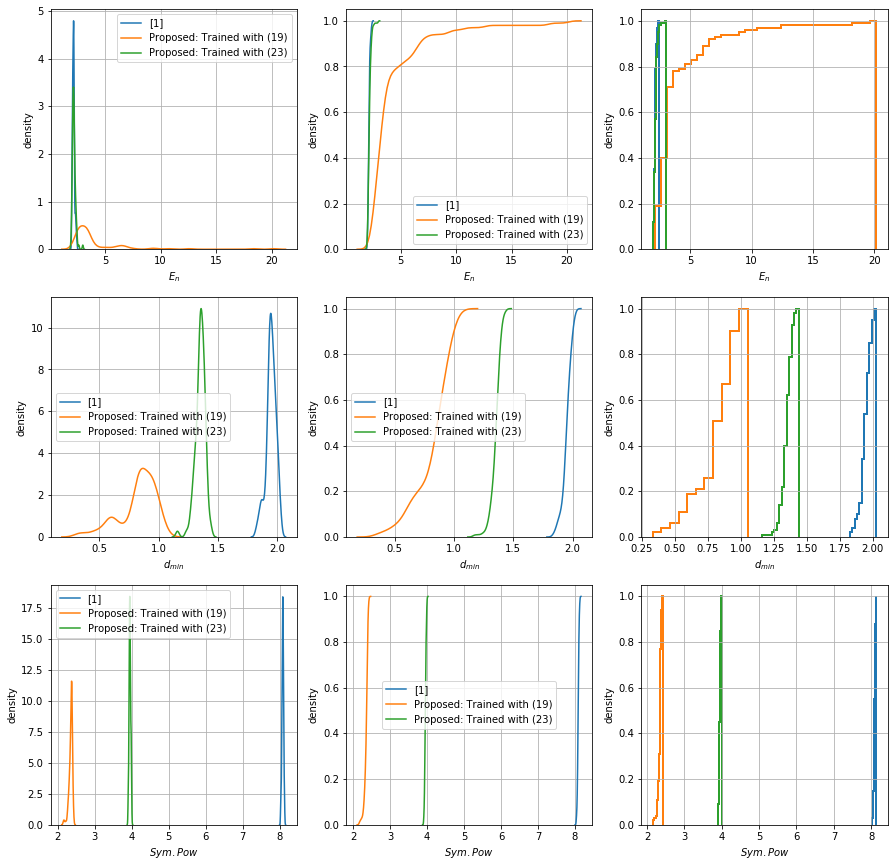

In [35]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))

# Plot each subfigure
for (model, result) in data.items():
    sns.distplot(result["en"], label=model, rug=False, hist=False, kde=True, ax=ax[0,0], kde_kws=dict(cumulative=False))
    sns.distplot(result["en"], label=model, rug=False, hist=False, kde=True, ax=ax[0,1], kde_kws=dict(cumulative=True))
    sns.distplot(result["en"], label=model, kde=False, ax=ax[0,2], hist_kws=dict(cumulative=True, density=True, histtype="step", linewidth=2, alpha=1.0))
    
    sns.distplot(result["dmin"], label=model, rug=False, hist=False, kde=True, ax=ax[1,0], kde_kws=dict(cumulative=False))
    sns.distplot(result["dmin"], label=model, rug=False, hist=False, kde=True, ax=ax[1,1], kde_kws=dict(cumulative=True))
    sns.distplot(result["dmin"], label=model, kde=False, ax=ax[1,2], hist_kws=dict(cumulative=True, density=True, histtype="step", linewidth=2, alpha=1.0))
                 
    sns.distplot(result["sym_pow"], label=model, rug=False, hist=False, kde=True, ax=ax[2,0], kde_kws=dict(cumulative=False))
    sns.distplot(result["sym_pow"], label=model, rug=False, hist=False, kde=True, ax=ax[2,1], kde_kws=dict(cumulative=True))
    sns.distplot(result["sym_pow"], label=model, kde=False, ax=ax[2,2], hist_kws=dict(cumulative=True, density=True, histtype="step", linewidth=2, alpha=1.0))

ax[0,0].grid()
ax[0,0].set_xlabel("$E_n$")
ax[0,0].set_ylabel("density")

ax[0,1].grid()
ax[0,1].set_xlabel("$E_n$")
ax[0,1].set_ylabel("density")

ax[0,2].grid()
ax[0,2].set_xlabel("$E_n$")
ax[0,2].set_ylabel("density")

ax[1,0].grid()
ax[1,0].set_xlabel("$d_{min}$")
ax[1,0].set_ylabel("density")

ax[1,1].grid()
ax[1,1].set_xlabel("$d_{min}$")
ax[1,1].set_ylabel("density")

ax[1,2].grid()
ax[1,2].set_xlabel("$d_{min}$")
ax[1,2].set_ylabel("density")

ax[2,0].grid()
ax[2,0].set_xlabel("$Sym. Pow$")
ax[2,0].set_ylabel("density")

ax[2,1].grid()
ax[2,1].set_xlabel("$Sym. Pow$")
ax[2,1].set_ylabel("density")

ax[2,2].grid()
ax[2,2].set_xlabel("$Sym. Pow$")
ax[2,2].set_ylabel("density")

In [36]:
# fig = plt.figure()

# for (model, result) in data.items():
# #     sns.jointplot(x=result["sym_pow"], y=result["dmin"])
# #     g = sns.pairplot(result)
#     g = sns.PairGrid(result)
#     g.map_diag(sns.kdeplot)
# #     g.map_offdiag(sns.kdeplot, n_levels=6);
#     g.map_offdiag(plt.scatter)
#     g.fig.suptitle(model)

In [37]:
# n = len(data.keys())
# # fig, ax = plt.subplots(1, n, figsize=(n*3.5,3))
# fig = plt.figure(figsize=(n*3.5, 3))

# for (label, result) in data.items():
#     g = sns.JointGrid(x=result["dmin"], y=result["sym_pow"])
#     g.plot_joint(sns.kdeplot)
#     g.ax_marg_y.set_xlim(0,7)

Plot $E_n$ v/s BLER ar each SNR

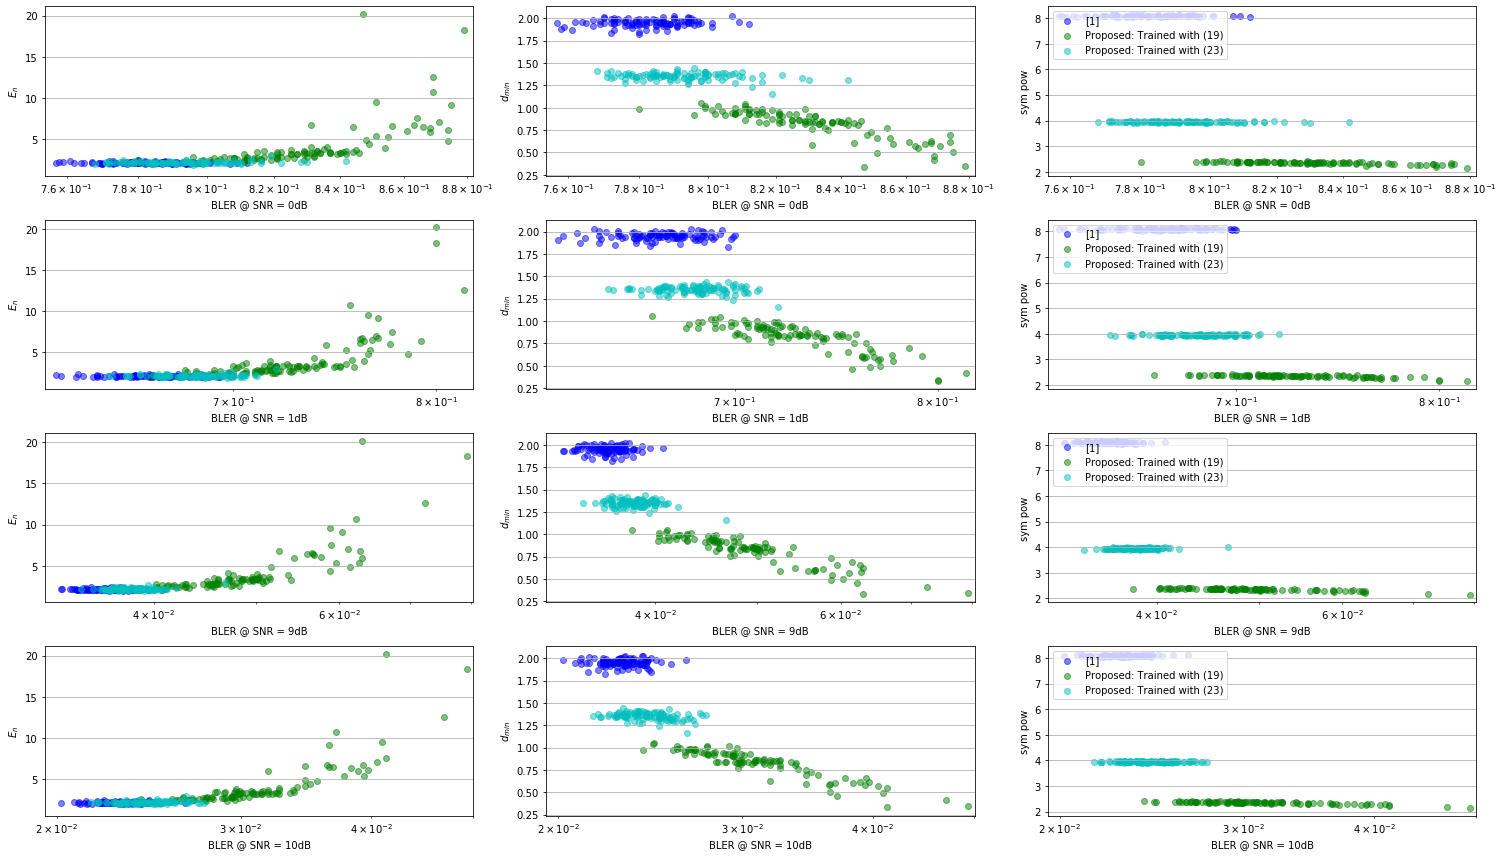

In [38]:
snr_list = [ 0, 1 , 9, 10 ] # List of indices in the SNR to plot, may not necesarily be tht actual SNR value
n_snr = len(snr_list)

fig, ax = plt.subplots(n_snr, 3, figsize=(21,3*n_snr))

for (idx, snr) in enumerate(snr_list):
    colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
    
    bler_min = +np.inf
    bler_max = -np.inf
    en_min = +np.inf
    en_max = -np.inf
    dmin_min = +np.inf
    dmin_max = -np.inf
    sympow_min = +np.inf
    sympow_max = -np.inf
    
    # Plot each subfigure
    for (model, result) in data.items():
        color = next(colors)
        en_data = result['en']  # Extract energy_density data
        dmin_data = result['dmin']
        sympow_data = result['sym_pow']
        bler_data = list(map(lambda x: x[snr], result['bler']))  # Extract BLER to corresponding SNR
        
        en_min = np.minimum(en_min, np.min(en_data))
        en_max = np.maximum(en_max, np.max(en_data))
        dmin_min = np.minimum(dmin_min, np.min(dmin_data))
        dmin_max = np.maximum(dmin_max, np.max(dmin_data))
        bler_min = np.minimum(bler_min, np.min(bler_data))
        bler_max = np.maximum(bler_max, np.max(bler_data))
        sympow_min = np.minimum(sympow_min, np.min(sympow_data))
        sympow_max = np.minimum(sympow_max, np.max(sympow_data))

        ax[idx,0].scatter(bler_data, en_data, c=color, label=model, alpha=0.5)
        ax[idx,1].scatter(bler_data, dmin_data, c=color, label=model, alpha=0.5)
        ax[idx,2].scatter(bler_data, sympow_data, c=color, label=model, alpha=0.5)
    
    ax[idx,0].set_xscale('log')
    ax[idx,0].set_ylabel("$E_n$")
    ax[idx,0].set_xlabel("BLER @ SNR = {}dB".format(snr))
    ax[idx,0].set_xlim([bler_min-0.025*(bler_max-bler_min), bler_max+0.025*(bler_max-bler_min)])
    ax[idx,0].grid()
    
    ax[idx,1].set_xscale('log')
    ax[idx,1].set_ylabel("$d_{min}$")
    ax[idx,1].set_xlabel("BLER @ SNR = {}dB".format(snr))
    ax[idx,1].set_xlim([bler_min-0.025*(bler_max-bler_min), bler_max+0.025*(bler_max-bler_min)])
    ax[idx,1].grid()
#     _ax[1].legend(loc="upper left")

    ax[idx,2].set_xscale('log')
    ax[idx,2].set_ylabel("sym pow")
    ax[idx,2].set_xlabel("BLER @ SNR = {}dB".format(snr))
    ax[idx,2].set_xlim([bler_min-0.025*(bler_max-bler_min), bler_max+0.025*(bler_max-bler_min)])
    ax[idx,2].grid()
    ax[idx,2].legend(loc="upper left") 
        
fig.tight_layout()
plt.savefig("analysis_bler_{:02d}x{:02d}.png".format(blkSize,chDim), format='png', bbox_inches='tight')